# Caravan insurance prediction

- author: Balázs Nagy
- e-mail: [balazs_nagy@outlook.com](balazs_nagy@outlook.com)
- date of submission: 09-03-2022

This data set contains information on customers of an insurance company. The data consists of $86$ variables and includes product usage data and socio-demographic data derived from zip area codes. The data was collected to answer the following question:

> Can you predict who would be interested inbuying a caravan insurance policy and give an explanation why?

Information about customers consists of $86$ variables and includes product usage data and socio-demographic data derived from zip area codes. The data was supplied by the Dutch data mining company Sentient Machine Research and is based on a real world business problem. The training set contains over $5000$ descriptions of customers, including the information of whether or not they have a caravan insurance policy. A test set contains $4000$ customers of whom only the organisers know if they have a caravan insurance policy.

Each observation corresponds to a postal code. Variables beginning with `M` refer to demographic statistics of the postal code, while variables beginning with `P` and `A` (as well as CARAVAN, the target variable) refer to product ownership and insurance statistics in the postal code.

In [1]:
import pandas as pd
import numpy as np

# Pre-processing

In [2]:
mapping = {'L0': {'desc': "customer subtype",
                  'values': {1: 'High Income, expensive child',
                             2: 'Very Important Provincials',
                             3: 'High status seniors',
                             4: 'Affluent senior apartments',
                             5: 'Mixed seniors',
                             6: 'Career and childcare',
                             7: "Dinki's (double income no kids)",
                             8: 'Middle class families',
                             9: 'Modern, complete families',
                             10: 'Stable family',
                             11: 'Family starters',
                             12: 'Affluent young families',
                             13: 'Young all american family',
                             14: 'Junior cosmopolitan',
                             15: 'Senior cosmopolitans',
                             16: 'Students in apartments',
                             17: 'Fresh masters in the city',
                             18: 'Single youth',
                             19: 'Suburban youth',
                             20: 'Etnically diverse',
                             21: 'Young urban have-nots',
                             22: 'Mixed apartment dwellers',
                             23: 'Young and rising',
                             24: 'Young, low educated',
                             25: 'Young seniors in the city',
                             26: 'Own home elderly',
                             27: 'Seniors in apartments',
                             28: 'Residential elderly',
                             29: 'Porchless seniors: no front yard',
                             30: 'Religious elderly singles',
                             31: 'Low income catholics',
                             32: 'Mixed seniors',
                             33: 'Lower class large families',
                             34: 'Large family, employed child',
                             35: 'Village families',
                             36: "Couples with teens 'Married with children",
                             37: 'Mixed small town dwellers',
                             38: 'Traditional families',
                             39: 'Large religous families',
                             40: 'Large family farms',
                             41: 'Mixed rurals'}},
           'L1': {'desc': 'average age keys',
                  'values':  {1: '20-30 years',
                              2: '30-40 years',
                              3: '40-50 years',
                              4: '50-60 years',
                              5: '60-70 years',
                              6: '70-80 years'}
                  },
           'L2': {'desc': 'customer main type keys',
                  'values': {1: 'Successful hedonists',
                             2: 'Driven Growers',
                             3: 'Average Family',
                             4: 'Career Loners',
                             5: 'Living well',
                             6: 'Cruising Seniors',
                             7: 'Retired and Religeous',
                             8: 'Family with grown ups',
                             9: 'Conservative families',
                             10: 'Farmers'}
                  },
           'L3': {'desc': 'percentage keys',
                  'values': {0: '0%',
                             1: '1 - 10%',
                             2: '11 - 23%',
                             3: '24 - 36%',
                             4: '37 - 49%',
                             5: '50 - 62%',
                             6: '63 - 75%',
                             7: '76 - 88%',
                             8: '89 - 99%',
                             9: '100%'}
                  },
           'L4': {'desc': 'total number keys',
                  'values': {0: '0',
                             1: '1 - 49',
                             2: '50 - 99',
                             3: '100 - 199',
                             4: '200 - 499',
                             5: '500 - 999',
                             6: '1000 - 4999',
                             7: '5000 - 9999',
                             8: '10,000 - 19,999',
                             9: '>= 20,000'}
                 }
           }

In [3]:
# meta information pre-prepared based on description.txt
desc = pd.read_excel('data/description.xlsx', sheet_name='meta')
# train data
train = pd.read_csv('data/ticdata2000.txt', delimiter='\t', names=desc.Header)
# evaluation data (caravan columns is empty)
test = pd.read_csv('data/ticeval2000.txt', delimiter='\t', names=desc.Header)
# create index for test
test.index = list(range(max(train.index) + 1, max(train.index) + 1 + test.shape[0]))
# join into single dataframe
data_raw = pd.concat([train.assign(source='train'), test.assign(source='test')])

In [4]:
# no null values in train data, no null values in test except 'caravan'
data_raw.isna().sum()[data_raw.isna().sum() != 0]

caravan    4000
dtype: int64

In [5]:
# share of ppl who owns an insurance in the train set: 6%
train.caravan.value_counts(normalize=True)

0    0.940227
1    0.059773
Name: caravan, dtype: float64

## Mappers

In [6]:
desc.Mapper.value_counts(dropna=False)

L4     42
L3     38
NaN     3
L1      1
L2      1
L0      1
Name: Mapper, dtype: int64

In [7]:
desc[desc.Mapper.isna()]

,Header,Description,Mapper
1,maanthui,Number of houses 1 - 10,NaN
2,mgemomv,Avg size household 1 - 6,NaN
85,caravan,Number of mobile home policies 0 - 1 (TARGET V...,NaN


There are no mappers for the above. `caravan` is a binary target, the remaining two will be used as a numerical variable. All other features will be mapped using the mapper provided and then we will apply one-hot encoding to the features.

In [8]:
# apply mapping to all categorical columns including two and multi-level categorical features
data = data_raw.copy()
for col, row in desc.set_index('Header').iterrows():
    try:
        key = mapping.get(row["Mapper"]).get('values')
        data[col] = data[col].map(key)
        # print(f'{col}: {key} - {key}')
    except AttributeError:
        pass

In [9]:
# check to see whether the mapping was complete
miss_per_col = data.isna().sum().sort_values()
miss_per_col[miss_per_col > 0]

apersaut       1
caravan     4000
dtype: int64

For `caravan` the missing values correspond to the test data which is OK.

In [10]:
# apersaut has 1 missing value
missing_index = data[data.apersaut.isna()].index[0]
missing_row = data_raw.iloc[missing_index]
print('Value not mapped:', missing_row.apersaut)
print('Source:', missing_row.source)

Value not mapped: 12
Source: test


We have one unmapped record from the prediction test set. The reason is that the corresponding mapper to `apersaut` has levels ranging from 0-9. We will replace this value.

In [11]:
desc[desc.Header == 'apersaut'] # L4 mapping can map between 0-9

,Header,Description,Mapper
67,apersaut,Number of car policies,L4


In [12]:
# replace with max value for 9: '>= 20,000'
data.loc[missing_index, 'apersaut'] = '>= 20,000'

In [13]:
miss_per_col = data.isna().sum().sort_values()
miss_per_col[miss_per_col > 0]

caravan    4000
dtype: int64

There are no more missing values, we may proceed with the encoding of categorical variables.

## One-hot encoding

In [14]:
data_dummied = pd.get_dummies(data, drop_first=True)
train_dummied = data_dummied[data_dummied.source_train == 1].drop(['source_train'], axis=1).copy()
test_dummied  = data_dummied[data_dummied.source_train == 0].drop(['source_train', 'caravan'], axis=1).copy()

# Model fitting

**Competition rules**

1. Objective: predict the CARAVAN column of the evaluation data
2. Models:
    - first competition: only random forests
    - second competition: any model
3. Metric: balanced accuracy

BA = (TPR + TNR) / 2

- TPR = TP / (TP + FN)
- TNR = TN = (TN + FP)

where `TP`, `FP`, `TN`, `FN` are the number of true positives, false positives, true negatives, false negatives.

In [20]:
from time import time

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

# random seed
SEED = 42

In [21]:
y = train_dummied.caravan.copy()
X = train_dummied.drop(['caravan'], axis=1).copy()

## Resampling

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

resampler = RandomOverSampler()
#resampler = RandomUnderSampler()
#resampler = SMOTE()

X_train_res, y_train_res = resampler.fit_resample(X_train, y_train)

# print(y_train_res.value_counts(), '\n')

clf = RandomForestClassifier(max_depth=5, class_weight='balanced', max_features='sqrt')
clf.fit(X_train_res, y_train_res)

y_pred = clf.predict(X_test)
acc_train = balanced_accuracy_score(y_train_res, clf.predict(X_train_res))
acc_test = balanced_accuracy_score(y_test, y_pred)
print(f'Train balanced accuracy: {acc_train}')
print(f'Validation balanced accuracy: {acc_test}')

print(f'Percentage of negative predictions: {np.sum(y_pred == 0) / len(y_pred)}')

Train balanced accuracy: 0.7929384965831435
Validation balanced accuracy: 0.7175584255842558
Percentage of negative predictions: 0.7381974248927039


## Best baseline resamplers and classifiers

### Single resampling

In [53]:
# list of resamplers
resamplers = [RandomOverSampler(),
              RandomUnderSampler(),
              SMOTE()]
# list of classifiers
classifiers = [
    KNeighborsClassifier(),
    SVC(probability=False),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB()
]

# list to store results
results = [] 

# fit baseline resamplers and classfieirs
for resampler in resamplers:
    for clf in classifiers:
        # resampler and classifier names
        name_res, name_clf = resampler.__class__.__name__, clf.__class__.__name__
        # resample training set
        X_train_res, y_train_res = resampler.fit_resample(X_train, y_train)
        # fit classfier
        clf.fit(X_train_res, y_train_res)
        # predict validation set
        y_pred = clf.predict(X_test)
        # calculate balanced accuracy scores
        acc_train = balanced_accuracy_score(y_train_res, clf.predict(X_train_res))
        acc_test = balanced_accuracy_score(y_test, y_pred)
        result = [name_res, name_clf, clf.get_params(), acc_train, acc_test]
        results.append(result)
        print(f'{name_res}-{name_clf}: {acc_train:.3f} (train), {acc_test:.3f} (test)')
    print('\n')
results = pd.DataFrame(results, columns=['resampler', 'classifier', 'params', 'acc_train', 'acc_test'])
results.sort_values(by='acc_test', ascending=False, inplace=True)

RandomOverSampler-KNeighborsClassifier: 0.938 (train), 0.548 (test)
RandomOverSampler-SVC: 0.950 (train), 0.558 (test)
RandomOverSampler-DecisionTreeClassifier: 0.996 (train), 0.518 (test)
RandomOverSampler-RandomForestClassifier: 0.996 (train), 0.526 (test)
RandomOverSampler-AdaBoostClassifier: 0.770 (train), 0.687 (test)
RandomOverSampler-GradientBoostingClassifier: 0.858 (train), 0.684 (test)
RandomOverSampler-GaussianNB: 0.601 (train), 0.490 (test)


RandomUnderSampler-KNeighborsClassifier: 0.715 (train), 0.553 (test)
RandomUnderSampler-SVC: 0.878 (train), 0.673 (test)
RandomUnderSampler-DecisionTreeClassifier: 0.996 (train), 0.626 (test)
RandomUnderSampler-RandomForestClassifier: 0.996 (train), 0.668 (test)
RandomUnderSampler-AdaBoostClassifier: 0.811 (train), 0.666 (test)
RandomUnderSampler-GradientBoostingClassifier: 0.914 (train), 0.692 (test)
RandomUnderSampler-GaussianNB: 0.730 (train), 0.598 (test)


SMOTE-KNeighborsClassifier: 0.887 (train), 0.472 (test)
SMOTE-SVC: 0.968 (t

In [61]:
results

,resampler,classifier,params,acc_train,acc_test
12,RandomUnderSampler,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.913858,0.691512
4,RandomOverSampler,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.770046,0.687332
5,RandomOverSampler,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.858087,0.684320
8,RandomUnderSampler,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.878277,0.672709
10,RandomUnderSampler,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.996255,0.667919
11,RandomUnderSampler,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.810861,0.666074
9,RandomUnderSampler,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.996255,0.626475
13,RandomUnderSampler,GaussianNB,"{'priors': None, 'var_smoothing': 1e-09}",0.730337,0.598202
18,SMOTE,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.902392,0.590030
1,RandomOverSampler,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.949658,0.557959


The top3 baseline models were:
1. GradientBoosting with random undersampling
2. AdaBoost with random over sampling
3. GradientBoosting with random oversampling

followed by SVC and RandomForest with random undersampling.

Although the top5 test scores range between 65-70%. However, the train scores suggests overfitting on the train set.
We try to overcome this by combining resampling techniques in the hope that this results a more generalised learning.

### Combined resampling

In [76]:
from itertools import permutations

In [93]:
# list of resamplers
resamplers = [RandomOverSampler(),
              RandomUnderSampler(),
              SMOTE()]
# list of classifiers
classifiers = [
    KNeighborsClassifier(),
    SVC(probability=False),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB()
]

results = []
for res1, res2 in permutations(resamplers, r=2):
    for clf in classifiers:
        name_res1, name_res2 = res1.__class__.__name__, res2.__class__.__name__
        name_clf = clf.__class__.__name__
        # create pipeline
        pipe = Pipeline([('res1', res1),
                         ('res2', res2),
                          ('clf', clf)])
        # fit model
        pipe.fit(X_train, y_train)
        # predict validation set
        y_pred = pipe.predict(X_test)
        # calculate balanced accuracy scores
        acc_train = balanced_accuracy_score(y_train_res, pipe.predict(X_train_res))
        acc_test = balanced_accuracy_score(y_test, y_pred)
        result = [name_res1, name_res2, name_clf,
                  clf.get_params(), acc_train, acc_test]
        results.append(result)
        print(f'{name_res1}-{name_res2}-{name_clf}: {acc_train:.3f} (train), {acc_test:.3f} (test)')
    print('\n')
    
results = pd.DataFrame(data=results,
                       columns=['resampler1', 'resampler2', 'classifier', 'params', 'acc_train', 'acc_test'])
results.sort_values(by='acc_test', ascending=False, inplace=True)

RandomOverSampler-RandomUnderSampler-KNeighborsClassifier: 0.909 (train), 0.547 (test)
RandomOverSampler-RandomUnderSampler-SVC: 0.656 (train), 0.565 (test)
RandomOverSampler-RandomUnderSampler-DecisionTreeClassifier: 0.806 (train), 0.524 (test)
RandomOverSampler-RandomUnderSampler-RandomForestClassifier: 0.657 (train), 0.533 (test)
RandomOverSampler-RandomUnderSampler-AdaBoostClassifier: 0.703 (train), 0.678 (test)
RandomOverSampler-RandomUnderSampler-GradientBoostingClassifier: 0.741 (train), 0.699 (test)
RandomOverSampler-RandomUnderSampler-GaussianNB: 0.601 (train), 0.490 (test)


RandomOverSampler-SMOTE-KNeighborsClassifier: 0.911 (train), 0.550 (test)
RandomOverSampler-SMOTE-SVC: 0.657 (train), 0.566 (test)
RandomOverSampler-SMOTE-DecisionTreeClassifier: 0.823 (train), 0.525 (test)
RandomOverSampler-SMOTE-RandomForestClassifier: 0.647 (train), 0.527 (test)
RandomOverSampler-SMOTE-AdaBoostClassifier: 0.711 (train), 0.691 (test)
RandomOverSampler-SMOTE-GradientBoostingClassifier: 0

In [94]:
results

,resampler1,resampler2,classifier,params,acc_train,acc_test
26,RandomUnderSampler,SMOTE,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.704100,0.706733
19,RandomUnderSampler,RandomOverSampler,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.700797,0.701768
25,RandomUnderSampler,SMOTE,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.660706,0.698784
5,RandomOverSampler,RandomUnderSampler,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.740547,0.698510
12,RandomOverSampler,SMOTE,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.734738,0.696665
22,RandomUnderSampler,SMOTE,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.652506,0.696369
24,RandomUnderSampler,SMOTE,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.727790,0.693533
11,RandomOverSampler,SMOTE,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.710706,0.690737
4,RandomOverSampler,RandomUnderSampler,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.702961,0.677930
15,RandomUnderSampler,RandomOverSampler,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.699772,0.676222


We got similar results, but decreased the overfitting on the train set.

<AxesSubplot:>

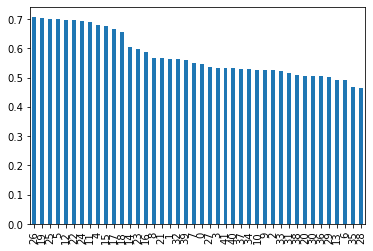

In [100]:
results.acc_test.plot(kind='bar')

## Random forest

In [102]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [118]:
RandomUnderSampler().get_params()

{'random_state': None, 'replacement': False, 'sampling_strategy': 'auto'}

In [140]:
pipe = Pipeline([('res1', RandomUnderSampler(random_state=SEED)),
                 ('res2', SMOTE(random_state=SEED)),
                 ('clf', RandomForestClassifier(random_state=SEED))])

param_grid = {
    'clf__max_features': ['log2', 'sqrt', 'auto'],
    'clf__max_depth': list(range(1, 6)) + [None],
    'clf__n_estimators': [100, 250, 500],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__class_weight': [None, 'balanced', 'balanced_subsample']
}

gs = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring='balanced_accuracy', cv=5, verbose=1)
gs.fit(X_train, y_train)

best_rf = gs.best_estimator_['clf']
results_rf = pd.DataFrame(gs.cv_results_)
print(f'Best model: {best_rf}')
print('Balanced accuracy on the test set', balanced_accuracy_score(y_test, best_rf.predict(X_test)))

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Best model: RandomForestClassifier(class_weight='balanced_subsample', max_depth=3,
                       max_features='sqrt', min_samples_leaf=4,
                       n_estimators=250, random_state=42)
Balanced accuracy on the test set 0.7021206323174343


## Gradient boosting

In [141]:
GradientBoostingClassifier().get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [142]:
pipe = Pipeline([('res1', RandomUnderSampler(random_state=SEED)),
                 ('res2', SMOTE(random_state=SEED)),
                 ('clf', GradientBoostingClassifier(random_state=SEED))])

param_grid = {
    'clf__max_features': ['log2', 'sqrt', 'auto'],
    'clf__max_depth': list(range(1, 6)) + [None],
    'clf__n_estimators': [100, 200, 250],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__learning_rate': [0.001, 0.01, 0.1]
}

gs = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring='balanced_accuracy', cv=5, verbose=1)
gs.fit(X_train, y_train)

best_gb = gs.best_estimator_['clf']
results_gb = pd.DataFrame(gs.cv_results_)
print(f'Best model: {best_gb}')
print('Balanced accuracy on the test set', balanced_accuracy_score(y_test, best_gb.predict(X_test)))

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Best model: GradientBoostingClassifier(learning_rate=0.001, max_depth=4,
                           max_features='sqrt', min_samples_leaf=4,
                           random_state=42)
Balanced accuracy on the test set 0.7133672725616145


# Submissions

> Submission format: `.txt` file, the nth row should be your prediction for the nth element of the test set; filename should be `dm_competition2_[your_name]_submission[submission_number].txt`. Pay attention to submit your predictions in the same order as they are in the test set. (`ticeval2000.txt`)

You can submit *one file* for each competition.

In [143]:
def create_submission(model):
    return pd.DataFrame({'Id': test.index.values,
                         'Caravan': model.predict(test_dummied)})\
             .set_index('Id')

In [144]:
# example of the layout
create_submission(best_rf).sample(10)

,Caravan
Id,
6667,0.0
9161,0.0
7746,1.0
7430,1.0
7581,0.0
9470,0.0
6251,0.0
7556,0.0
9498,0.0


In [145]:
my_name = 'Balázs-Nagy'
for name, model in {'1': best_rf, '2': best_gb}.items():
    print(model)
    df_submission = create_submission(model=model)
    filename = f'dm_competition2_{my_name}_submission{name}.txt'
    df_submission.to_csv(filename, index=False, header=None)
    print(df_submission.sample(5), '\n' + '*'*75 + '\n')

RandomForestClassifier(class_weight='balanced_subsample', max_depth=3,
                       max_features='sqrt', min_samples_leaf=4,
                       n_estimators=250, random_state=42)
      Caravan
Id           
7086      0.0
8045      0.0
9006      0.0
6111      0.0
9567      1.0 
***************************************************************************

GradientBoostingClassifier(learning_rate=0.001, max_depth=4,
                           max_features='sqrt', min_samples_leaf=4,
                           random_state=42)
      Caravan
Id           
8555      0.0
6184      0.0
6270      0.0
7074      1.0
7204      1.0 
***************************************************************************

